In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import scipy
import numba
import torch
import numpy as np
import pandas as pd
import ase.io as aio
from ase import Atoms
import scipy.io as sio
import atomistics as amks
from scipy.stats import moment
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from toolz.curried import pipe, curry

you can install PyFFTW for speed-up as - 
conda install -c conda-forge pyfftw


In [3]:
import filters
import stats as astat
import utilities as utils

In [5]:
# from ase.neighborlist import neighbor_list
# from asap3.analysis.localstructure import RestrictedCNA

In [4]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [5]:
try:
    import pyfftw
    np.fftpack = pyfftw.interfaces.numpy_fft
    pyfftw.interfaces.cache.enable()
except ImportError:
    print("you can install PyFFTW for speed-up as - ")
    print("conda install -c conda-forge pyfftw")
    pass


fftn = curry(np.fft.fftn)  # pylint: disable=invalid-name

ifftn = curry(np.fft.ifftn)  # pylint: disable=invalid-name

ifftshift = curry(np.fft.ifftshift)

conj = curry(np.conj)

fabs = curry(lambda x: np.absolute(x))

torch_rfft = curry(torch.rfft)

torch_irfft = curry(torch.irfft)

torch_numpy = curry(torch.from_numpy)

fftshift = curry(np.fft.fftshift)

@curry
def conjugate(x):
    y = torch.empty_like(x)
    y[..., 1] = 0
    y[..., 0] = x[... , 0]**2 + x[..., 1]**2
    return y

@curry
def conjugate_mult(x1, x2):
    y = torch.empty_like(x1)
    y[..., 0] = x1[..., 0] * x2[..., 0] + x1[..., 1] * x2[..., 1]
    y[..., 1] = x1[..., 1] * x2[..., 0] - x1[..., 0] * x2[..., 1]
    return y

def imfilter_torch(x_data, f_data):
    ndim = x_data.ndim
    f_data = torch.from_numpy(f_data).double()
    func = conjugate_mult(x1=torch.rfft(f_data, 
                                        signal_ndim=ndim))
    return pipe(x_data, 
                lambda x: torch.from_numpy(x),
                lambda x: x.double(),
                torch_rfft(signal_ndim=ndim), 
                lambda x: func(x2=x), 
                torch_irfft(signal_ndim=ndim), 
                fftshift)
        
@curry
def write2vtk(matrix, fname="zeo.vtk"):
    """
    args:
    matrix: numpy ndArray
    fname : filename
    """
    sx, sy, sz = matrix.shape
    mx = np.max(matrix)
    mi = np.min(matrix)
    lines ='# vtk DataFile Version 2.0\nVolume example\nASCII\nDATASET STRUCTURED_POINTS\nDIMENSIONS %d %d %d\nASPECT_RATIO 1 1 1\nORIGIN 0 0 0\nPOINT_DATA %d\nSCALARS matlab_scalars float 1\nLOOKUP_TABLE default\n'%(sx, sy, sz, matrix.size)
    with open(fname, 'w') as f:
        f.write(lines)
        for ix in range(sz):
            v = np.ravel(matrix[:,:,ix], order="f")
            v = ["%1.5f"%x for x in np.round(100 * v / mx)]
            line = " ".join(v)
            f.write(line+"\n")

you can install PyFFTW for speed-up as - 
conda install -c conda-forge pyfftw


In [9]:
def get_coords(fname):
    with open(fname, "r") as f:
        lines = f.readlines()
    n_atoms = int(lines[3].split(" ")[0])
    box_dim = []
    box_dim.append([float(x) for x in lines[5].split(" ")[:2]])
    box_dim.append([float(x) for x in lines[6].split(" ")[:2]])
    box_dim.append([float(x) for x in lines[7].split(" ")[:2]])
    lines = lines[9:n_atoms+9]
    coords = (np.array([[line.split(" ")[0]]+line.split(" ")[2:5] for line in lines])).astype(float)
    return coords[np.argsort(coords[:,0])][:,1:], np.array(box_dim)


def get_GBcoords(atom, cutoff=3.0):
    cna = RestrictedCNA(atom, cutoff)
    tags = cna.atoms.get_tags()
    idx = np.where(tags != 0)[0]
    
    coords = atom.get_positions()
    coords = np.concatenate([coords, np.arange(len(atom))[:,None]], axis=1)
    
    coords_irr = coords[idx]
    return coords_irr[:,:3], coords_irr[:,3].astype(int)

# Load reference structure

In [5]:
# pka = 1000
# fname = "../data/cu_reference/dump.ref.{}".format(pka)
# coords_ref, box_dim = get_coords(fname)

In [6]:
# run = 10
# fname = "../data/cu_transfer/{}/dump.que.{}".format(pka, run)

# # diffs, box_dim = get_coords(fname)
# # coords_all = coords_ref + diffs

# coords_all, box_dim = get_coords(fname)
# print("Total no. of atoms: %d" % coords_all.shape[0])

# cell = [(box_dim[i,1] - box_dim[i,0]) for i in range(3)] 

# pbc = [1, 1, 1]

# atoms_0 = Atoms(positions=coords_all, cell=cell, pbc=pbc)

# coords_irr, indexes = get_GBcoords(atoms_0, cutoff=2.8)
# print("No. of Cascade Atoms: %d" % len(indexes))

# atoms_1 = Atoms(positions=coords_irr, cell=cell, pbc=pbc)

In [12]:
from ase import Atoms 
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

runs = np.loadtxt("runs.txt").astype(int)

In [13]:
%%time
ix=10
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
             lambda f: utils.load_file(f), 
             lambda a: get_atoms(a))

idx = np.where(atoms.get_tags() != 1)[0]
print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))

if len(idx) == 0:
    np.random.seed(81396)
    idx = np.random.randint(low=0, high=len(atoms), size=2000)

coords_all = atoms.get_positions()
coords_sub = coords_all[idx]

obj = utils.load_file("data/stat_indxs_cutoff_150/dump.arc.{}_stat.pkl".format(runs[ix]))
indexes = obj["indexes"]

total atoms: 4000000, disturbed atoms: 244316
CPU times: user 9.26 s, sys: 3.26 s, total: 12.5 s
Wall time: 5.59 s


In [14]:
atoms_0 = Atoms(positions=coords_all, cell=atoms.get_cell(), pbc=atoms.get_pbc())
atoms_1 = Atoms(positions=coords_sub,  cell=atoms.get_cell(), pbc=atoms.get_pbc())

# Visualization of the Cascade 

In [15]:
import poremks.porosity as pore
import poremks.grid_generator as gen

In [11]:
atom_ids = sorted(np.unique(atoms_1.get_chemical_symbols()))

radii = {}
for idx in atom_ids:
    radii[idx] = 5.0

In [12]:
%%time
len_pixel = 1
S, S_list, box_dim = gen.grid_maker(atoms_1, len_pixel=len_pixel, atomic_radii=radii, full=False, fft=False)
print(S.shape)

(364, 364, 364)
CPU times: user 15.8 s, sys: 1.13 s, total: 16.9 s
Wall time: 4.78 s


In [13]:
S_cas = S_list[0]
print(np.count_nonzero(S_cas))

12684751


In [37]:
# To generate vtk file of the accessible void region for visualization
write2vtk(S_cas, "run_{}_cascade.vtk".format(runs[10]))

In [38]:
from poremks.correlations import compute_statistics

In [39]:
S_gg = compute_statistics(boundary="nonperiodic", corrtype="auto", cutoff=100, device=torch.device("cpu"), args0=S_cas)

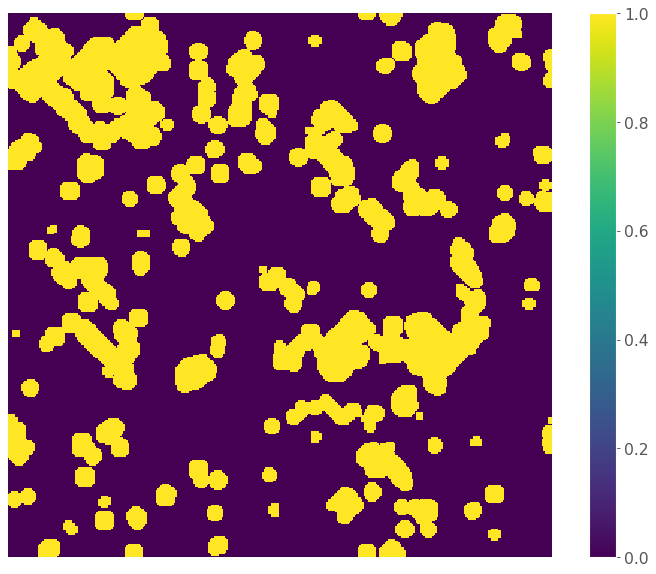

In [41]:
utils.draw_im(S_cas[:,:,182])

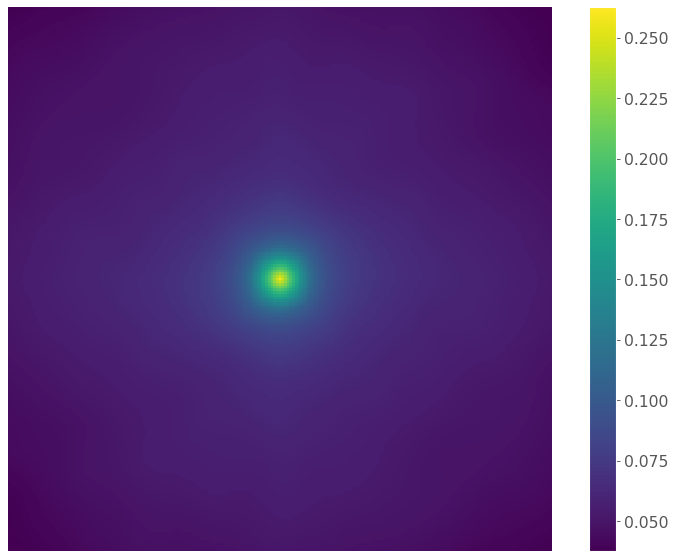

In [43]:
utils.draw_im(S_gg[:,:,100])

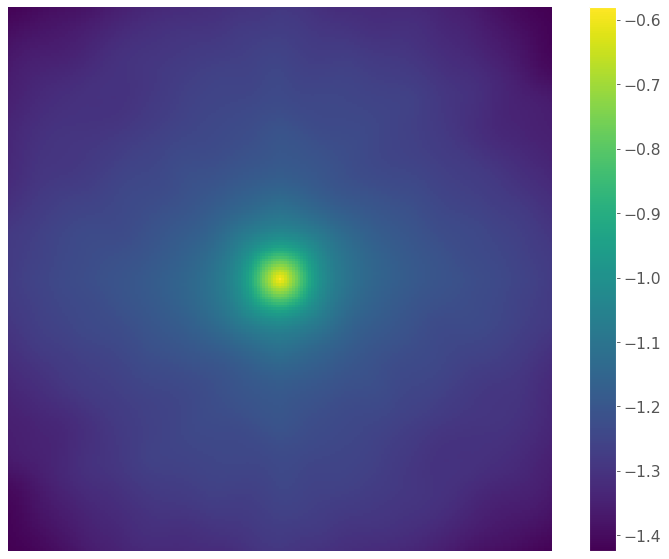

In [42]:
utils.draw_im(np.log10(S_gg[:,:,100]))

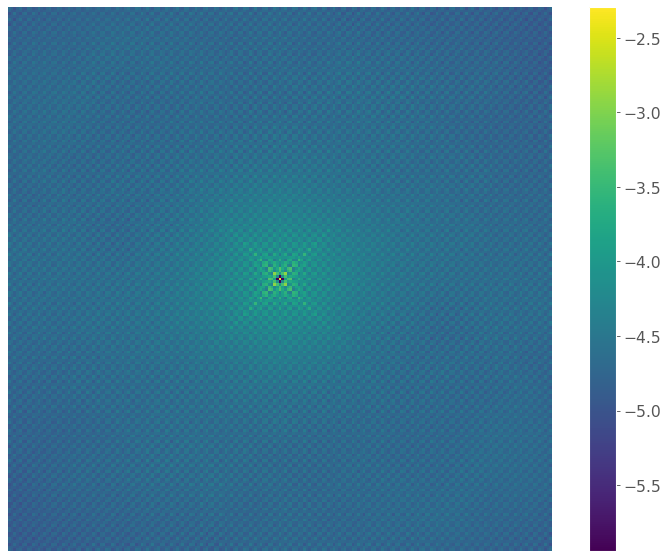

In [33]:
utils.draw_im(np.log10(S_gg[:,:,100]))

# Feature Extraction from the cascade

In [36]:
asa = pore.get_asa(S_cas, len_pixel=len_pixel)
print("Probe Accessible Surface Area: %1.3f" % asa)
av = np.count_nonzero(S_cas) * (1 / len_pixel)**3
print("Probe Accessible Volume: %1.3f" % av)

Probe Accessible Surface Area: 103666.000
Probe Accessible Volume: 8723.000


In [37]:
S_l, n_count, m = pore.return_labelled(S_cas)

In [38]:
print("No. of unconnected regions: {}".format(n_count))

No. of unconnected regions: 8701


In [40]:
write2vtk(S_l, "pka_{}_run_{}_cascade_colored.vtk".format(pka,run))

## Generate skeletonized representation

In [43]:
strt = time.time()
S_skel = pipe(S_cas, 
           lambda x: pore.gen_medialAxis(x))
end = time.time()
print("Medial Path Computation Time: %1.3fs" % (end-strt))

Medial Path Computation Time: 0.010s


In [44]:
write2vtk(S_skel, "pka_{}_run_%d_cascade_skeleton.vtk".format(pka,run))